# Train a Classifier to detect traffic lights

##### Udacity Self-Driving Car Nanodegree
##### project system integration
##### team vulture

This approach follows very closely the one documented in https://github.com/cena0805/ros-traffic-light-classifier as this is almost what we need.

Rainer Bareiss, V0.4, August 22th, 2017, Lago Maggiore

## 1 imports

In [51]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
#from visual_callbacks import AccLossPlotter
import numpy as np
import glob
import os
from PIL import Image
import collections
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
from keras.models import Model
from keras.layers import Input, Activation, merge
from keras.layers import Flatten, Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import AveragePooling2D
from keras.optimizers import Adam
import keras.backend as K
#from dataHandler import dataHandler
#from consts import *


K.set_image_dim_ordering('tf')

# import neural nets
import model 
import model_2

## 2 parameters

In [52]:
batch_size = 64 #8 #64
nb_epoch = 50 #25 #3 #25
nb_train_samples = 2000

# save file into directory download
save_img = False

## 3 load & explore model

In [53]:
# Option 1: original model from https://github.com/cena0805/ros-traffic-light-classifier
model = model.get_model()
#model = model_2.get_model_2()

# Option 2: squeezenet from https://github.com/mynameisguy/TrafficLightChallenge-DeepLearning-Nexar/blob/master/train.py
#model = model.SqueezeNet(nb_classes=3, inputs=(64, 64, 3))
#model = model.SqueezeNet()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_5 (Convolution2D)  (None, 64, 64, 32)    896         convolution2d_input_6[0][0]      
____________________________________________________________________________________________________
activation_7 (Activation)        (None, 64, 64, 32)    0           convolution2d_5[0][0]            
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 62, 62, 32)    9248        activation_7[0][0]               
____________________________________________________________________________________________________
activation_8 (Activation)        (None, 62, 62, 32)    0           convolution2d_6[0][0]            
___________________________________________________________________________________________

In [57]:
"""
IMAGE_HEIGHT = 224 #64
IMAGE_WIDTH = 224 #64
NB_CLASSES = 3

def SqueezeNet(nb_classes=3, inputs=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)):
    # Keras Implementation of SqueezeNet(arXiv 1602.07360)
    # @param nb_classes: total number of final categories
    # Arguments:
    # inputs -- shape of the input images (channel, cols, rows)
    #

    input_img = Input(shape=inputs)
    conv1 = Convolution2D(96, 7, 7, activation='relu', init='glorot_uniform', subsample=(2, 2), border_mode='same', name='conv1')(input_img)
    maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool1')(conv1)

    fire2_squeeze = Convolution2D(16, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire2_squeeze')(maxpool1)
    fire2_expand1 = Convolution2D(64, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire2_expand1')(fire2_squeeze)
    fire2_expand2 = Convolution2D(64, 3, 3, activation='relu', init='glorot_uniform',border_mode='same', name='fire2_expand2')(fire2_squeeze)
    merge2 = merge([fire2_expand1, fire2_expand2], mode='concat', concat_axis=-1)

    fire3_squeeze = Convolution2D(16, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire3_squeeze')(merge2)
    fire3_expand1 = Convolution2D(64, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire3_expand1')(fire3_squeeze)
    fire3_expand2 = Convolution2D(64, 3, 3, activation='relu', init='glorot_uniform',border_mode='same', name='fire3_expand2')(fire3_squeeze)
    merge3 = merge([fire3_expand1, fire3_expand2], mode='concat', concat_axis=-1)

    fire4_squeeze = Convolution2D(32, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire4_squeeze')(merge3)
    fire4_expand1 = Convolution2D(128, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire4_expand1')(fire4_squeeze)
    fire4_expand2 = Convolution2D(128, 3, 3, activation='relu', init='glorot_uniform',border_mode='same', name='fire4_expand2')(fire4_squeeze)
    merge4 = merge([fire4_expand1, fire4_expand2], mode='concat', concat_axis=-1)
    maxpool4 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool4')(merge4)

    fire5_squeeze = Convolution2D(32, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire5_squeeze')(maxpool4)
    fire5_expand1 = Convolution2D(128, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire5_expand1')(fire5_squeeze)
    fire5_expand2 = Convolution2D(128, 3, 3, activation='relu', init='glorot_uniform',border_mode='same', name='fire5_expand2')(fire5_squeeze)
    merge5 = merge([fire5_expand1, fire5_expand2], mode='concat', concat_axis=-1)

    fire6_squeeze = Convolution2D(48, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire6_squeeze')(merge5)
    fire6_expand1 = Convolution2D(192, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire6_expand1')(fire6_squeeze)
    fire6_expand2 = Convolution2D(192, 3, 3, activation='relu', init='glorot_uniform',border_mode='same', name='fire6_expand2')(fire6_squeeze)
    merge6 = merge([fire6_expand1, fire6_expand2], mode='concat', concat_axis=-1)

    fire7_squeeze = Convolution2D(48, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire7_squeeze')(merge6)
    fire7_expand1 = Convolution2D(192, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire7_expand1')(fire7_squeeze)
    fire7_expand2 = Convolution2D(192, 3, 3, activation='relu', init='glorot_uniform',border_mode='same', name='fire7_expand2')(fire7_squeeze)
    merge7 = merge([fire7_expand1, fire7_expand2], mode='concat', concat_axis=-1)

    fire8_squeeze = Convolution2D(64, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire8_squeeze')(merge7)
    fire8_expand1 = Convolution2D(256, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire8_expand1')(fire8_squeeze)
    fire8_expand2 = Convolution2D(256, 3, 3, activation='relu', init='glorot_uniform',border_mode='same', name='fire8_expand2')(fire8_squeeze)
    merge8 = merge([fire8_expand1, fire8_expand2], mode='concat', concat_axis=-1)

    maxpool8 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool8')(merge8)

    fire9_squeeze = Convolution2D(64, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire9_squeeze')(maxpool8)
    fire9_expand1 = Convolution2D(256, 1, 1, activation='relu', init='glorot_uniform',border_mode='same', name='fire9_expand1')(fire9_squeeze)
    fire9_expand2 = Convolution2D(256, 3, 3, activation='relu', init='glorot_uniform',border_mode='same', name='fire9_expand2')(fire9_squeeze)
    merge9 = merge([fire9_expand1, fire9_expand2], mode='concat', concat_axis=-1)

    fire9_dropout = Dropout(0.5, name='fire9_dropout')(merge9)
    conv10 = Convolution2D(nb_classes, 1, 1, init='glorot_uniform',border_mode='valid', name='conv10')(fire9_dropout)
    # The size should match the output of conv10

    avgpool10 = AveragePooling2D((13, 13), name='avgpool10')(conv10)
    flatten = Flatten(name='flatten')(avgpool10)
    softmax = Activation("softmax", name='softmax')(flatten)

    #return Model(input=input_img, output=softmax)
    return model #(input=input_img, output=softmax)

model_sn = SqueezeNet(3, (IMAGE_HEIGHT, IMAGE_WIDTH, 3))
model_sn.summary()
"""

'\nIMAGE_HEIGHT = 224 #64\nIMAGE_WIDTH = 224 #64\nNB_CLASSES = 3\n\ndef SqueezeNet(nb_classes=3, inputs=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)):\n    # Keras Implementation of SqueezeNet(arXiv 1602.07360)\n    # @param nb_classes: total number of final categories\n    # Arguments:\n    # inputs -- shape of the input images (channel, cols, rows)\n    #\n\n    input_img = Input(shape=inputs)\n    conv1 = Convolution2D(96, 7, 7, activation=\'relu\', init=\'glorot_uniform\', subsample=(2, 2), border_mode=\'same\', name=\'conv1\')(input_img)\n    maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name=\'maxpool1\')(conv1)\n\n    fire2_squeeze = Convolution2D(16, 1, 1, activation=\'relu\', init=\'glorot_uniform\',border_mode=\'same\', name=\'fire2_squeeze\')(maxpool1)\n    fire2_expand1 = Convolution2D(64, 1, 1, activation=\'relu\', init=\'glorot_uniform\',border_mode=\'same\', name=\'fire2_expand1\')(fire2_squeeze)\n    fire2_expand2 = Convolution2D(64, 3, 3, activation=\'relu\', init=\'glor

In [6]:
# TODO: iplement squeezenet and compare accuracy & runtime for small data set

In [7]:
# ...

## 4 load data and split into training, validate and test data

In [8]:
# set data pathes
# input & output folder
mydir_in = '/Users/rainerbareiss/Library/Mobile Documents/M6HJR9W95L~com~textasticapp~textastic/Documents/02-Udacity/carND/03-term3/P3-CarND-Capstone/00-team_vulture/SDC-System-Integration/classifier/'
mydir_out = '/Users/rainerbareiss/Downloads/traffic_light_images/'
#mydir_in = '/Users/rainerbareiss/Library/Mobile Documents/M6HJR9W95L~com~textasticapp~textastic/Documents/02-Udacity/carND/03-term3/P3-CarND-Capstone/00-team_vulture/SDC-System-Integration/classifier'

In [9]:
#mydir = '/Users/rainerbareiss/Library/Mobile Documents/M6HJR9W95L~com~textasticapp~textastic/Documents/02-Udacity/carND/03-term3/P3-CarND-Capstone/90-sample_classifier/model'
#myfiles = glob.glob(mydir+"/images/*/*.*")

myfiles = glob.glob(mydir_in+"/images/*/*.*")

#print(myfiles)
train_samples, validation_samples = train_test_split(myfiles, test_size=0.2)
print(len(train_samples))
print(len(validation_samples))

34972
8744


## 5 prepare data fro training 

### input

/images:
    /red
    /green
    /unknown
    
### output (augmented)

/train:
    /red
    /green
    /unknown
    
/test:
    /red
    /green
    /unknown

### store training data into separate folder

In [10]:
# https://stackoverflow.com/questions/3397157/how-to-read-a-raw-image-using-pil

In [11]:
for ifile in train_samples:
    # read data
    file = Image.open(ifile)
    imgSize = file.size
    rawData = file.tobytes()
    
    # get class & file name
    classdir = ifile.split("/")[-2]   # class name
    classname = ifile.split("/")[-1]  # name of the image file
    #print(classdir + ' ---> ' + classname)
    
    # generate new file names
    ofile = mydir_out + 'train/' + classdir + '/' + classname
    #print(ofile)
    
    # save in new folder
    img = Image.frombytes('RGB', imgSize, rawData)
    if (save_img): img.save(ofile)
    #print(ifile)

In [12]:
datagen = ImageDataGenerator(width_shift_range=.2, height_shift_range=.2, shear_range=0.05, zoom_range=.1,
                             fill_mode='nearest', rescale=1. / 255)
train_image_data_gen = datagen.flow_from_directory(mydir_out+'train', target_size=(64, 64), classes=['green', 'red', 'unknown'],
                                             batch_size=batch_size)
print("number of image samples: ",train_image_data_gen.nb_sample)

Found 34972 images belonging to 3 classes.
number of image samples:  34972


### store test data into separate folder

In [13]:
y_ground_truth = []

for ifile in validation_samples:
    # read data
    file = Image.open(ifile)
    imgSize = file.size
    rawData = file.tobytes()
    
    # get class & file name
    classdir = ifile.split("/")[-2]   # class name
    classname = ifile.split("/")[-1]  # name of the image file
    #print(classdir + ' ---> ' + classname)
    
    # generate new file names
    ofile = mydir_out + 'test/' + classdir + '/' + classname
    #print(ofile)
    
    # save in new folder
    img = Image.frombytes('RGB', imgSize, rawData)
    if (save_img): img.save(ofile)
    #print(ifile)
    
    # generate vector of ground_truth
    if (classdir == 'green'): y_ground_truth.append([1,0,0])
    if (classdir == 'red'): y_ground_truth.append([0,1,0])
    if (classdir == 'unknown'): y_ground_truth.append([0,0,1])

In [14]:
test_image_data_gen = datagen.flow_from_directory(mydir_out+'test', target_size=(64, 64), classes=['green', 'red', 'unknown'],
                                             batch_size=batch_size)
print("number of image samples: ",test_image_data_gen.nb_sample)

Found 8744 images belonging to 3 classes.
number of image samples:  8744


## 6 train model

In [84]:
# no. lr     batch images <> model     <> Opt.    <> epochs  s/epoch <> loss           acc         >>> test acc.   
# ===================================================================================================================
# 001 ---    64    all    <> get_model <> RMSPROP <> 25      600s    <> loss: 0.25   - acc: 0.85,  >>> 44%
# 002 0.0001 64    2000   <> get_model <> SGD     <> 25       50s    <> loss: 0.3328 - acc: 0.8896 >>> 42.4%
# 003 0.001  64    2000   <> get_model <> SGD     <> 25       50s    <> loss: 0.1373 - acc: 0.9585 >>> 48.4% / 49.6%
# 004 0.001  16    2000   <> get_model <> SGD     <> 25       80s    <> loss: 0.1613 - acc: 0.9545 >>> 47.5% / 50.1%
# 005 0.001  128   2000   <> get_model <> SGD     <> 25       50s    <> loss: 0.1627 - acc: 0.9521 >>> 42.9%
# 006 0.005  64    2000   <> get_model <> SGD     <> 25       50s    <> loss: 0.1304 - acc: 0.9673 >>> 44.3%
# 007 0.001  64    all    <> get_model <> SGD     <> 50       850s   <> loss: 0.0919 - acc: 0.9737 >>> 50.0% <<<

# test accuracy is determined for predicting a completly unseen test dataset splitted from the original dataset

In [ ]:
# select optimizer compile model
# Option 1: rmsprop
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Option 2: Adams Optimizer
#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01) # original
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01) # original

#adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# test model with less data
# model.fit_generator(train_image_data_gen, nb_epoch=nb_epoch, samples_per_epoch=nb_train_samples)

# full model
model.fit_generator(train_image_data_gen, nb_epoch=nb_epoch, samples_per_epoch=train_image_data_gen.nb_sample)

Epoch 1/50
34972/34972 [==============================] - 827s - loss: 0.2739 - acc: 0.9134      

## 7 save model

In [ ]:
model.save('xxx_traffic_lights_classifier_basenet_sgd_epoch25.h5')

## 8 predict 

In [31]:
# helper functions

# Min-Max scaling for grayscale image data
# http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#about-min-max-scaling
def normalize_scale(X):
    a = 0
    b = 1.0
    return a + X * (b-a) / 255

# http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html
def standardize(X):
    X -= np.mean(X, axis = 0) # zero-center
    X /= np.std(X, axis = 0) # normalize
    return (X)

# preprocessing pipeline
def prepare_data(X):
    
    # step 1: convert to gray image
    #X = rgb2gray(X)
    
    # add the dimensions again in order for working with LeNet
    X = np.reshape(X, (X.shape[0],64,64,-1))
    
    # Step 2: Normalize RGB-values into interval [-1,1]    
    X = normalize_scale(X)

    # Step 3: Convert data to values with zero mean and std = 1
    X = standardize(X)
    return X

In [130]:
def reshape_image(image):
  x = img_to_array(image.resize((64, 64), Image.ANTIALIAS))
  #x = prepare_data(x)
  return x[None, :]

def show(filename):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    #image = Image.open(filename)
    #image.show()
    %pylab inline
    img=mpimg.imread(filename)
    imgplot = plt.imshow(img)
    plt.show()

model_predict = load_model('light_classifier_model.h5')

In [131]:
# Load Example Image
green = load_img(mydir_in + 'images_from_simulator/sampleout1.jpg')
samp = load_img(mydir_in + 'images_from_simulator/sim03.png')

# TODO: scale & crop before prediction!!!
#my_prob = model_predict.predict(reshape_image(green))
my_prob = model_predict.predict(reshape_image(samp))


print(my_prob)
print(my_prob[0][0])

[[ 0.  0.  1.]]
0.0


Populating the interactive namespace from numpy and matplotlib


/Users/rainerbareiss/Developer/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['show']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


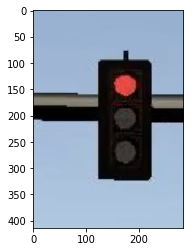

[[ 0.  0.  1.]]


In [132]:
# sample image
my_sample = 'images_from_simulator/sim03.png'

# show cropped image
%pylab inline
img=mpimg.imread(my_sample)
imgplot = plt.imshow(img)
plt.show()

# predict color of traffic light
samp = load_img(mydir_in + my_sample)
my_prob = model_predict.predict(reshape_image(samp))
print(my_prob) # green / red / unknown

## 9 analyse performance of model

In [133]:
# Option 1: orignal

In [134]:
# apply prediction over all test data 
myfiles = glob.glob(mydir_out+"/test/*/*.*")
my_pred = []

for ifile in myfiles:
    my_img = load_img(ifile)
    my_prob = model_predict.predict(reshape_image(my_img))
    my_pred.append([my_prob[0][0],my_prob[0][1],my_prob[0][2]])
    #print(max(my_prob))
print(len(my_pred))

KeyboardInterrupt: 

In [91]:
# generate array of indices showing the class number of prediction
my_pred_ind = []

for ipred in my_pred:
        imax = np.argwhere(ipred == np.amax(ipred))
        ##print(ipred, "     ", imax[0][0])
        my_pred_ind.append(imax[0][0])
        #if (imax[0][0] != 2): my_pred_ind.append(imax[0][0])
        
print(len(my_pred_ind))

8744


In [92]:
#print(y_ground_truth)

In [93]:
# generate array of indices showing the ground truth class
my_true_ind = []

for itrue in y_ground_truth:
        imax = np.argwhere(itrue == np.amax(itrue))
        ##print(ipred, "     ", imax[0][0])
        my_true_ind.append(imax[0][0])
        #if (imax[0][0] != 2): my_true_ind.append(imax[0][0])
        
print(len(my_true_ind))

8744


In [94]:
# check elementwise for equality and store result in vector
comp = np.equal(my_pred_ind, my_true_ind)
print("array of comparision: ",comp)

# count occurences of true
collections.Counter(comp)
mytrues = Counter(comp)
if (len(comp) != 0): 
    print("Accuracy of predicting new traffic lights from simulator = ", mytrues[1]/len(comp)*100,"%")
else:
    print("no red or green lights detected")

array of comparision:  [False False False ...,  True False  True]
Accuracy of predicting new traffic lights from simulator =  43.33257090576395 %


In [95]:
# Option 2: following https://stackoverflow.com/questions/44156974/how-to-interpret-keras-predict-generator-output

In [135]:
# dimensions of our images.
img_width, img_height = 64, 64

# set directory for test data
validation_data_dir=mydir_out+'test'

# setup data generator
test_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    classes=['green', 'red', 'unknown'])
    #class_mode='binary')
print(len(validation_generator.filenames))

# generate predictions
predictions=model_predict.predict_generator(validation_generator,len(validation_generator.filenames));
#print(predictions)

Found 8744 images belonging to 3 classes.
8744


In [136]:
# apply prediction over all test data 
myfiles = glob.glob(mydir_out+"/test/*/*.*")
my_pred = []

for ipred in predictions:
    #my_img = load_img(ifile)
    #my_prob = model_predict.predict(reshape_image(my_img))
    my_pred.append(ipred)
    #print(max(my_prob))
print(len(my_pred))

8744


In [137]:
# generate array of indices showing the class number of prediction
my_pred_ind = []

for ipred in my_pred:
        imax = np.argwhere(ipred == np.amax(ipred))
        ##print(ipred, "     ", imax[0][0])
        my_pred_ind.append(imax[0][0])
        #if (imax[0][0] != 2): my_pred_ind.append(imax[0][0])
        
print(len(my_pred_ind))

8744


In [138]:
#print(predictions)
# check elementwise for equality and store result in vector
comp = np.equal(my_pred_ind, my_true_ind)
print("array of comparision: ",comp)

# count occurences of true
collections.Counter(comp)
mytrues = Counter(comp)
if (len(comp) != 0): 
    print("Accuracy of predicting new traffic lights from simulator = ", mytrues[1]/len(comp)*100,"%")
else:
    print("no red or green lights detected")

array of comparision:  [False False  True ...,  True False  True]
Accuracy of predicting new traffic lights from simulator =  50.8348581884721 %


In [139]:
comp_red = comp[0:1758]
collections.Counter(comp_red)
mytrues_red = Counter(comp_red)
print(mytrues_red)
print("Accuracy red traffic lights = ", mytrues_red[0]/len(comp_red)*100,"%")

Counter({False: 882, True: 876})
Accuracy red traffic lights =  50.170648464163826 %


In [142]:
comp_green = comp[1759:2924]
collections.Counter(comp_green)
mytrues_green = Counter(comp_green)
print(mytrues_green)
print("Accuracy green traffic lights = ", mytrues_green[1]/len(comp_green)*100,"%")

Counter({True: 592, False: 573})
Accuracy green traffic lights =  50.81545064377683 %


In [143]:
comp_un = comp[2924:]
collections.Counter(comp_un)
mytrues_un = Counter(comp_un)
print(mytrues_un)
print("Accuracy unknown traffic lights = ", mytrues_un[1]/len(comp_un)*100,"%")

Counter({True: 2977, False: 2843})
Accuracy unknown traffic lights =  51.15120274914089 %
